In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
np.set_printoptions(suppress=True)

In [2]:
# The values of each action
ROCK,PAPER,SCISSORS = 0,1,2
# How many actions a player can take
NUM_ACTIONS = 3 
# Define strategy of the player (to start)
strategy = np.array([0.0, 0.0, 0.0])

In [3]:
def value(p1, p2):
    """ 
    Gets the reward value for a given turn
    p1, p2: The actions of the players
    """
    if p1 == p2:
        return 0
    elif (p1-1) % NUM_ACTIONS == p2:
        return 1
    else:
        return -1

In [4]:
def normalize(strategy):
    strategy = np.copy(strategy)
    normalizingSum = np.sum(strategy)
    if normalizingSum > 0:
        strategy /= normalizingSum
    else:
        strategy = np.ones(strategy.shape[0]) / strategy.shape[0]
    return strategy

In [5]:
def getStrategy(regretSum):
    return normalize(np.maximum(regretSum, 0))

In [6]:
def getAverageStrategy(strategySum):
    return normalize(strategySum)

In [7]:
def getAction(strategy):
    """
    Get a random action according to a mixed-strategy distribution
    """
    strategy = strategy / np.sum(strategy) # Normalize
    return np.searchsorted(np.cumsum(strategy), random.random())

In [8]:
def runGames(X, Y, strategy, oppStrategy, plot=True):
    """
    Compute and display the running monetary results of X rounds of Y games
    """
    roundResult = []
    for j in range(X):
        roundScore = 0
        for i in range(Y):
            myAction = getAction(strategy)
            otherAction = getAction(oppStrategy)
            roundScore += value(myAction, otherAction)
        roundResult.append(roundScore)
    if plot:
        plt.plot(sorted(roundResult))
        plt.xlabel("Round #")
        plt.ylabel("Round Result")
    
    return np.mean(roundResult), np.median(roundResult)

In [9]:
def innerTrain(regretSum, strategySum, oppStrategy):
    # Accumulate the current strategy based on regret
    strategy = getStrategy(regretSum)
    strategySum += strategy
        
    # Get regret-matched mixed strategy actions for both players
    myAction = getAction(strategy)
    otherAction = getAction(oppStrategy)
        
    # Compute the utility of each possible action from 'myAction' perspective
    actionUtility = np.zeros(NUM_ACTIONS)
    actionUtility[otherAction] = 0
    actionUtility[(otherAction + 1) % NUM_ACTIONS] = 1
    actionUtility[(otherAction - 1) % NUM_ACTIONS] = -1
    
    # Accumulate action regrets
    regretSum += actionUtility - actionUtility[myAction]
    
    return regretSum, strategySum

In [10]:
def train(iterations, oppStrategy, log=False):
    regretSum = np.zeros(NUM_ACTIONS)
    strategySum = np.zeros(NUM_ACTIONS)
    results = []

    for i in range(iterations):
        regretSum, strategySum = innerTrain(regretSum, strategySum, oppStrategy)
        if log:
            strategy = getAverageStrategy(strategySum)
            resultMean, resultMedian = runGames(1, 200, strategy, oppStrategy, plot=False)
            results.append(resultMedian)
    
    if log:
        plt.plot(np.convolve(results, np.ones(1000)/1000, mode='valid'))
        plt.xscale('log')
        plt.xlabel("Iteration #")
        plt.ylabel("Round Result")
    return strategySum

In [11]:
def train2p(oiterations, iterations, log=False):
    strategySumP1 = np.zeros(NUM_ACTIONS)
    strategySumP2 = np.zeros(NUM_ACTIONS)
    strategyStepsP1 = []
    strategyStepsP2 = []
    
    for j in range(oiterations):
        oppStrategy = getAverageStrategy(strategySumP2)
        regretSumP1 = np.zeros(NUM_ACTIONS)
        for i in range(iterations):
            # Train the first player
            regretSumP1, strategySumP1 = innerTrain(regretSumP1, strategySumP1, oppStrategy)
        
        oppStrategy = getAverageStrategy(strategySumP1)
        regretSumP2 = np.zeros(NUM_ACTIONS)
        for i in range(iterations):
            # Train the second player
            regretSumP2, strategySumP2 = innerTrain(regretSumP2, strategySumP2, oppStrategy)
        
        if log:
          print("%3d" % j, normalize(strategySumP1), normalize(strategySumP2))

        strategyStepsP1.append(normalize(strategySumP1))
        strategyStepsP2.append(normalize(strategySumP2))
        
    return strategySumP1, strategySumP2, strategyStepsP1, strategyStepsP2

mean: -0.355
median: 0.0


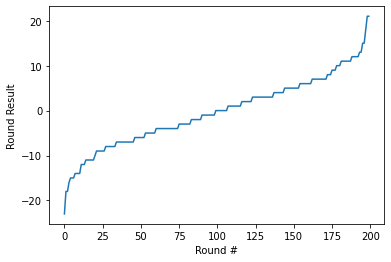

In [12]:
# Here we are not exploiting at all...
strategy = np.array([0.33,0.33,0.33])
oppStrategy = np.array([0.4, 0.3, 0.3])
resultMean, resultMedian = runGames(200, 100, strategy, oppStrategy)
print(f"mean: {resultMean}\nmedian: {resultMedian}")

mean: 10.045
median: 10.0


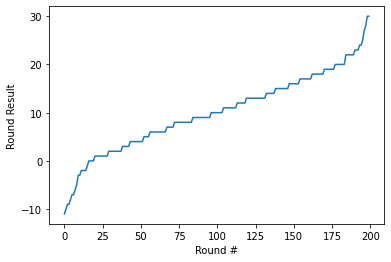

In [13]:
# Only throw paper, which is the optimal strategy for an agent that favours rock
strategy = np.array([0,1,0])
resultMean, resultMedian = runGames(200, 100, strategy, oppStrategy)
print(f"mean: {resultMean}\nmedian: {resultMedian}")

Rock %0.9953613946939882	Paper %98.8589048148103	Scissors %0.1457337904957099


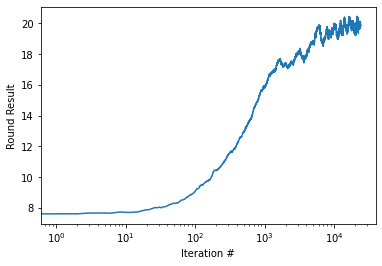

In [14]:
# Train against the fixed strategy
strategySum = train(25000, oppStrategy, log=True)
strategy = getAverageStrategy(strategySum)
print(f"Rock %{strategy[0]*100}\tPaper %{strategy[1]*100}\tScissors %{strategy[2]*100}")

mean: 10.665
median: 11.0


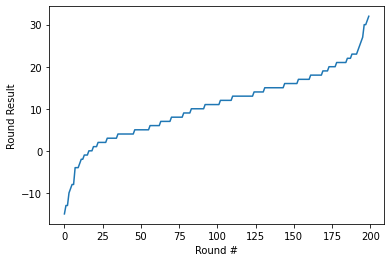

In [15]:
# Plot the trained strategy (1 player)
resultMean, resultMedian = runGames(200, 100, strategy, oppStrategy)
print(f"mean: {resultMean}\nmedian: {resultMedian}")

In [24]:
# Now play when both agents minimize regret
s1, s2, ss1, ss2 = train2p(20, 10000, log=True)

  0 [0.00816784 0.78781455 0.20401761] [0.00003333 0.00003333 0.99993333]
  1 [0.50403392 0.39392394 0.10204214] [0.00078241 0.49915926 0.50005833]
  2 [0.33623539 0.26262707 0.40113754] [0.33343748 0.33296046 0.33360206]
  3 [0.36078007 0.25599487 0.38322506] [0.49892074 0.25077362 0.25030563]
  4 [0.28866572 0.40474756 0.30658672] [0.39980125 0.20187384 0.39832491]
  5 [0.40550004 0.33899436 0.2555056 ] [0.33335268 0.33448461 0.33216271]
  6 [0.3475929  0.41665483 0.23575227] [0.28575706 0.42951776 0.28472518]
  7 [0.30437074 0.36550916 0.3301201 ] [0.25008326 0.37685189 0.37306485]
  8 [0.27103829 0.32495446 0.40400726] [0.33154425 0.33498687 0.33346888]
  9 [0.33291292 0.29284258 0.3742445 ] [0.39374898 0.30191831 0.30433271]
 10 [0.30421381 0.35517907 0.34060712] [0.3582644  0.27558594 0.36614965]
 11 [0.36168825 0.32604203 0.31226973] [0.33127624 0.33297023 0.33575353]
 12 [0.33861116 0.34994728 0.31144156] [0.30580285 0.37203652 0.32216063]
 13 [0.31468539 0.32514327 0.36017134]

In [25]:
s1 = getAverageStrategy(s1) 
s2 = getAverageStrategy(s2)
print(f"Player 1:\n\tRock %{s1[0]*100}\n\tPaper %{s1[1]*100}\n\tScissors %{s1[2]*100}")
print(f"Player 2:\n\tRock %{s2[0]*100}\n\tPaper %{s2[1]*100}\n\tScissors %{s2[2]*100}")

Player 1:
	Rock %32.72232287362635
	Paper %34.78881425279112
	Scissors %32.48886287358253
Player 2:
	Rock %33.23410192923461
	Paper %35.390144551905905
	Scissors %31.37575351885949


(-0.3, 0.0)

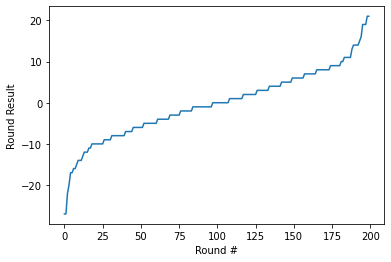

In [26]:
# Plot the trained strategy (2 player)
runGames(200, 100, s1, s2)

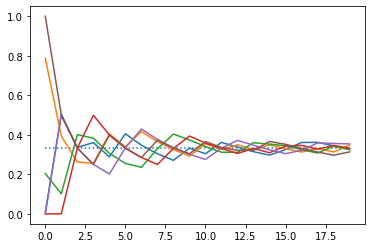

In [27]:
plt.plot(ss1)
plt.plot(ss2)
plt.hlines(1/3, 0, len(ss1) - 1, linestyles='dotted')

As can be seen above, when both players use CFR, the strategies approach [0.33333, 0.33333, 0.33333]. This is the logical resting place for this strategy going up against itself, as it will throw rock about 1/3rd of the time, throw paper about 1/3rd of the time, and throw scissors 1/3rd of the time.